In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/efficientnet_adam.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/val'
TEST_IMAGE_FOLDER = '/home/TBX11K/test'
SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

### EfficientNet Model

In [3]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable=False

hidden = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
batch_norm = tf.keras.layers.BatchNormalization()(hidden)
y = tf.keras.layers.Dense(3, activation="softmax", kernel_initializer="he_normal")(batch_norm)
eff_model = tf.keras.Model(inputs=base_model.input, outputs=y)
    
eff_model.summary()

2022-08-13 20:47:54.926035: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-13 20:47:54.926093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

#### Keras Callbacks

In [4]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(eff_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(eff_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 9130 images belonging to 3 classes.
Found 2032 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.972310969116081, 1: 1.0144444444444445, 2: 1.0144444444444445}
samples for train class labels: dict_items([(0, 3130), (1, 3000), (2, 3000)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 923), (1, 800), (2, 309)])


#### EfficientNet Compilation and Execution

In [6]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
eff_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [7]:
warnings.filterwarnings("ignore")
epochs = 20
history = eff_model.fit(train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=validation_generator, 
                                epochs=epochs,
                                verbose = 1,
                                class_weight = class_weights,
                                callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  0.001
Epoch 1/20


2022-08-13 20:48:39.301262: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


286/286 [==============================] - ETA: 0s - loss: 0.4700 - accuracy: 0.8165 - AUC: 0.9425 - precision: 0.8347 - recall: 0.7963
Epoch 00001: val_loss improved from inf to 0.51814, saving model to ./weights/efficientnet_adam.hdf5
End of epoch 0. Learning rate: 0.001
286/286 [==============================] - 120s 395ms/step - loss: 0.4700 - accuracy: 0.8165 - AUC: 0.9425 - precision: 0.8347 - recall: 0.7963 - val_loss: 0.5181 - val_accuracy: 0.8081 - val_AUC: 0.9259 - val_precision: 0.8208 - val_recall: 0.7820 - lr: 0.0010
Learning rate:  0.001
Epoch 2/20
286/286 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.8832 - AUC: 0.9726 - precision: 0.8928 - recall: 0.8724
Epoch 00002: val_loss improved from 0.51814 to 0.36486, saving model to ./weights/efficientnet_adam.hdf5
End of epoch 1. Learning rate: 0.001
286/286 [==============================] - 114s 397ms/step - loss: 0.3167 - accuracy: 0.8832 - AUC: 0.9726 - precision: 0.8928 - recall: 0.8724 - val_los

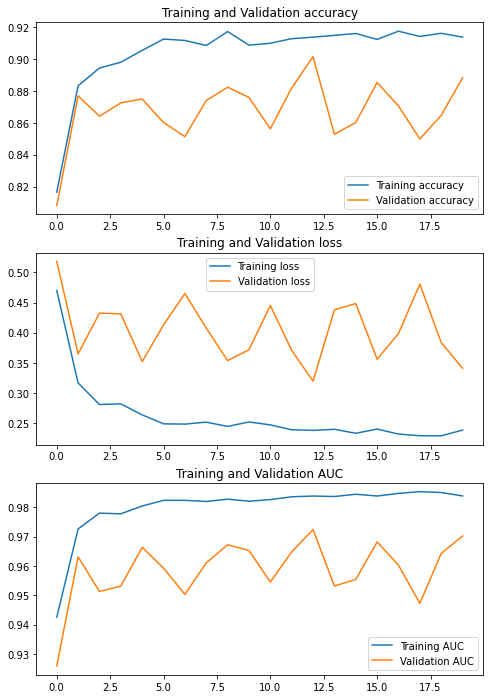

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [9]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_accuracy'],ascending=False)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
12,0.237993,0.913801,0.983772,0.919473,0.909200,0.319683,0.901575,0.972380,0.905164,0.897146,0.001
19,0.238483,0.913801,0.983805,0.919376,0.910515,0.341057,0.888287,0.970185,0.892468,0.886319,0.001
15,0.240191,0.912377,0.983782,0.918460,0.906791,0.356039,0.885335,0.968146,0.888503,0.882382,0.001
8,0.244534,0.917306,0.982702,0.923077,0.912158,0.353771,0.882382,0.967189,0.885913,0.878937,0.001
11,0.239041,0.912815,0.983512,0.917820,0.907667,0.370719,0.881890,0.964758,0.883929,0.876969,0.001
1,0.316710,0.883242,0.972555,0.892837,0.872399,0.364863,0.876969,0.963095,0.882236,0.870079,0.001
9,0.251984,0.908762,0.982012,0.914317,0.902300,0.371703,0.875984,0.965243,0.881390,0.874016,0.001
4,0.263689,0.905476,0.980382,0.913271,0.898467,0.352100,0.875000,0.966321,0.877916,0.870571,0.001
7,0.251702,0.908543,0.981923,0.914771,0.902848,0.407536,0.874016,0.961003,0.878412,0.871063,0.001


#### EfficientNet Fine tuning

In [10]:
for layer in eff_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

eff_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [11]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
eff_model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [12]:
history_finetune = eff_model.fit(train_generator,
                            epochs=45,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 20/45
286/286 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9163 - AUC: 0.9837 - precision: 0.9194 - recall: 0.9137
Epoch 00020: val_loss did not improve from 0.31968
End of epoch 19. Learning rate: 1e-04
286/286 [==============================] - 129s 426ms/step - loss: 0.2455 - accuracy: 0.9163 - AUC: 0.9837 - precision: 0.9194 - recall: 0.9137 - val_loss: 0.3865 - val_accuracy: 0.8947 - val_AUC: 0.9701 - val_precision: 0.8980 - val_recall: 0.8927 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 21/45
286/286 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9456 - AUC: 0.9908 - precision: 0.9477 - recall: 0.9448
Epoch 00021: val_loss did not improve from 0.31968
End of epoch 20. Learning rate: 1e-04
286/286 [==============================] - 125s 438ms/step - loss: 0.1675 - accuracy: 0.9456 - AUC: 0.9908 - precision: 0.9477 - recall: 0.9448 - val_loss: 0.3594 - val_accuracy: 0.9183 - val_AUC: 

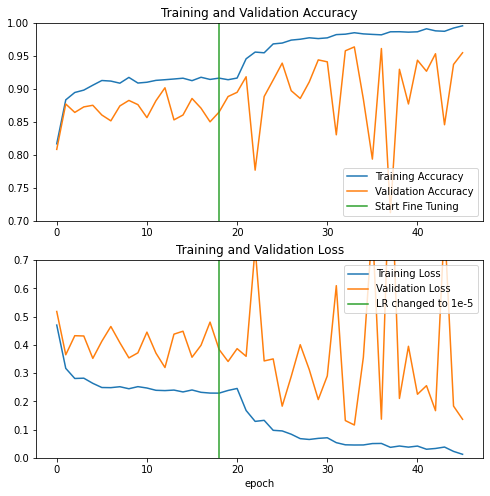

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
initial_epochs=history.epoch[-1]

acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.7])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='LR changed to 1e-5')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
13,0.045291,0.985104,0.998872,0.985317,0.984885,0.116130,0.963583,0.995831,0.963565,0.963091,0.000100
12,0.046003,0.982913,0.998848,0.983560,0.982913,0.131869,0.957677,0.993940,0.958149,0.957677,0.000100
25,0.012413,0.995619,0.999875,0.995728,0.995619,0.136370,0.954724,0.994019,0.955150,0.953740,0.000032
16,0.050860,0.981928,0.998828,0.982679,0.981818,0.136728,0.961122,0.994019,0.961595,0.961122,0.000100
22,0.033022,0.987952,0.999214,0.988274,0.987733,0.166898,0.953248,0.992159,0.953248,0.953248,0.000100
5,0.095167,0.969441,0.995864,0.969833,0.968346,0.182840,0.938976,0.988889,0.939349,0.937500,0.000100
24,0.022690,0.992223,0.999540,0.992331,0.992114,0.183130,0.937008,0.990876,0.938272,0.935039,0.000032
9,0.068821,0.976232,0.997671,0.976966,0.975575,0.206221,0.943898,0.989285,0.943898,0.943898,0.000100
18,0.041743,0.986637,0.998843,0.986959,0.986418,0.210163,0.929626,0.988328,0.930473,0.928642,0.000100


In [21]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
eff_model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

history_finetune2 = eff_model.fit(train_generator,
                            epochs=60,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-05
Epoch 45/60
286/286 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9962 - AUC: 0.9999 - precision: 0.9964 - recall: 0.9961
Epoch 00045: val_loss did not improve from 0.11613
End of epoch 44. Learning rate: 1e-05
286/286 [==============================] - 135s 443ms/step - loss: 0.0107 - accuracy: 0.9962 - AUC: 0.9999 - precision: 0.9964 - recall: 0.9961 - val_loss: 0.1694 - val_accuracy: 0.9493 - val_AUC: 0.9920 - val_precision: 0.9502 - val_recall: 0.9488 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 46/60
286/286 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9965 - AUC: 1.0000 - precision: 0.9968 - recall: 0.9963
Epoch 00046: val_loss did not improve from 0.11613
End of epoch 45. Learning rate: 1e-05
286/286 [==============================] - 126s 439ms/step - loss: 0.0106 - accuracy: 0.9965 - AUC: 1.0000 - precision: 0.9968 - recall: 0.9963 - val_loss: 0.2116 - val_accuracy: 0.9345 - val_AUC: 

In [22]:
hist_df = pd.DataFrame(history_finetune2.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
15,0.005309,0.998248,0.999993,0.998248,0.998248,0.123604,0.966043,0.993445,0.966027,0.965551,0.00001
8,0.008844,0.997043,0.999977,0.997151,0.996824,0.133060,0.961122,0.993774,0.962050,0.960630,0.00001
6,0.007633,0.997481,0.999985,0.997481,0.997481,0.135684,0.955709,0.994264,0.955709,0.955709,0.00001
10,0.007264,0.997590,0.999985,0.997590,0.997590,0.137522,0.958169,0.994260,0.958641,0.958169,0.00001
13,0.006246,0.997919,0.999988,0.997919,0.997919,0.138748,0.959646,0.992748,0.959626,0.959154,0.00001
14,0.008453,0.997262,0.999978,0.997480,0.997152,0.154061,0.953248,0.991922,0.953179,0.951772,0.00001
5,0.007363,0.997481,0.999905,0.997590,0.997481,0.158434,0.951280,0.992891,0.952217,0.951280,0.00001
4,0.009919,0.995728,0.999973,0.995728,0.995619,0.161713,0.953740,0.992159,0.954657,0.953248,0.00001
7,0.007800,0.997809,0.999901,0.997809,0.997809,0.165342,0.950295,0.991396,0.950763,0.950295,0.00001


#### Montgomery County Dataset Evaluation

In [17]:
TEST_IMAGE_FOLDER = '/home/TBX11K/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = eff_model.predict(test_generator)

Found 69 images belonging to 3 classes.


- Evaluate model 

In [18]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.78      0.82        40
           2       0.73      0.83      0.77        29

    accuracy                           0.80        69
   macro avg       0.79      0.80      0.79        69
weighted avg       0.80      0.80      0.80        69



#### Shenzhen Dataset Evaluation

In [19]:
TEST_IMAGE_FOLDER = '/home/TBX11K/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = eff_model.predict(test_generator)

Found 331 images belonging to 3 classes.


In [20]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       163
           2       0.82      0.91      0.86       168

    accuracy                           0.85       331
   macro avg       0.86      0.85      0.85       331
weighted avg       0.86      0.85      0.85       331

